<h1>Importing necessary libraries</h1>

In [1]:
!pip install tensorflow


  Using cached tensorflow-2.12.0-cp311-cp311-win_amd64.whl (1.9 kB)


In [2]:
import pandas as pd
import numpy as np
import re
import collections
import matplotlib.pyplot as plt
import tensorflow as tf
import itertools
import nltk

# Packages for data preparation

from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from keras_preprocessing.text import Tokenizer
from nltk.tokenize import word_tokenize
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Packages for modelling

from keras import models
from keras import layers
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.layers.convolutional import Conv1D,MaxPooling1D
from keras.preprocessing import sequence
from keras.layers import Dense, Flatten, Activation, Dropout
from keras import regularizers

from sklearn.metrics import confusion_matrix

ModuleNotFoundError: No module named 'nltk'

<h1>Data Loading into Pandas Data Frames</h1>

In [3]:
df = pd.read_csv("tweets.csv")
df.head(10)

,Tweet,Label
0,"When this India tour of Australia started, I k...",NR
1,US to help Iraq build base for Mosul push - Th...,NR
2,What @thetimes didn't know is Taqiya (lies) is...,NR
3,#WilayatAlFallujah\n\nNew Video : The Knights ...,R
4,US Defense Secretary Carter in Baghdad to disc...,NR
5,At least 8 civilians killed in today's #Russia...,R
6,RT @deSyracuse: #Syria #map - Ongoing Loyalist...,R
7,@biblio_phile__ ahhahahahahhahaha,R
8,RT @Qassami_Marwan: When Islamic state videos ...,R
9,ISIS link: 21 people are missing from Kerala h...,NR


In [4]:
df.shape

(16000, 2)

In [5]:
def get_missings(df):
    labels,values = list(),list()
    if df.isna().sum().sum()>0:
        for column in df.columns:
            if df[column].isnull().sum():
                labels.append(column)
                values.append((df[column].isnull().sum() / len(df[column]))*100)

        #Make a dataframe 
        missings=pd.DataFrame({'Features':labels,'MissingPercent':values }).sort_values(by='MissingPercent',ascending=False)
        plt.figure(figsize=(10,6))
        sns.barplot(x=missings.Features,y=missings.MissingPercent, palette="Blues_d").set_title('Percentage of Missing Values')
        return missings
    else:
        print("There are no missing values!")
        return False

get_missings(df)

There are no missing values!


False

<h1>Data-preprocessing</h1>

<b>Case Conversion</b>

In [6]:
df['Tweet']= df['Tweet'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df['Tweet'].head()

0    when this india tour of australia started, i k...
1    us to help iraq build base for mosul push - th...
2    what @thetimes didn't know is taqiya (lies) is...
3    #wilayatalfallujah new video : the knights of ...
4    us defense secretary carter in baghdad to disc...
Name: Tweet, dtype: object

<b>Remove Usernames & HTTP Links</b>

In [7]:
def remove_usernames_links(Tweet):
    Tweet = re.sub('@[^\s]+','',Tweet)
    Tweet = re.sub('http[^\s]+','',Tweet)
    return Tweet
df['Tweet'] = df['Tweet'].apply(remove_usernames_links)

In [8]:
df.head(10)

,Tweet,Label
0,"when this india tour of australia started, i k...",NR
1,us to help iraq build base for mosul push - th...,NR
2,what didn't know is taqiya (lies) is synonymo...,NR
3,#wilayatalfallujah new video : the knights of ...,R
4,us defense secretary carter in baghdad to disc...,NR
5,at least 8 civilians killed in today's #russia...,R
6,rt #syria #map - ongoing loyalist offensive i...,R
7,ahhahahahahhahaha,R
8,rt when islamic state videos are banned in yo...,R
9,isis link: 21 people are missing from kerala,NR


<b>Remove Hashtag Symbol and Keep Key Words</b>

In [9]:
df['Tweet'] = df['Tweet'].str.replace("#", "").replace("_", " ")
#for removing whole hashtag "#[A-Za-z0-9_]+"

In [10]:
df.head()

,Tweet,Label
0,"when this india tour of australia started, i k...",NR
1,us to help iraq build base for mosul push - th...,NR
2,what didn't know is taqiya (lies) is synonymo...,NR
3,wilayatalfallujah new video : the knights of v...,R
4,us defense secretary carter in baghdad to disc...,NR


<b>Removing Punctuation</b>

In [11]:
df['Tweet']=df['Tweet'].str.replace('[^\w\s]','')
df['Tweet'].head()

0    when this india tour of australia started, i k...
1    us to help iraq build base for mosul push - th...
2    what  didn't know is taqiya (lies) is synonymo...
3    wilayatalfallujah new video : the knights of v...
4    us defense secretary carter in baghdad to disc...
Name: Tweet, dtype: object

<b>Removal of Stop Word</b>

In [12]:
>>> nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [13]:
from nltk.corpus import stopwords

In [14]:
additional  = ['rt','rts','retweet']
swords = set().union(stopwords.words('english'),additional)
df['Tweet']= df['Tweet'].apply(lambda x:" ".join(x for x in x.split() if x not in swords))


In [15]:
df.head(10)

,Tweet,Label
0,"india tour australia started, knew kohli close...",NR
1,us help iraq build base mosul push - indian ex...,NR
2,know taqiya (lies) synonymous rafida.,NR
3,wilayatalfallujah new video : knights victory ...,R
4,us defense secretary carter baghdad discuss pl...,NR
5,least 8 civilians killed today's russia|n airs...,R
6,syria map - ongoing loyalist offensive south a...,R
7,ahhahahahahhahaha,R
8,islamic state videos banned nusra base try fin...,R
9,isis link: 21 people missing kerala,NR


<b>Rare Words Removal</b>

In [16]:
freq=pd.Series(" ".join(df['Tweet']).split()).value_counts()[-1000:]
freq

discovered,.               1
haditha..                  1
sme                        1
bcause                     1
ev/s/htvd                  1
                          ..
эмбонт                     1
,50                        1
aki                        1
smallcoffinsareheaviest    1
southaleppo                1
Name: count, Length: 1000, dtype: int64

In [17]:
tweetText = df['Tweet']
tweetText = tweetText.apply(word_tokenize)
tweetText.head()

0    [india, tour, australia, started, ,, knew, koh...
1    [us, help, iraq, build, base, mosul, push, -, ...
2    [know, taqiya, (, lies, ), synonymous, rafida, .]
3    [wilayatalfallujah, new, video, :, knights, vi...
4    [us, defense, secretary, carter, baghdad, disc...
Name: Tweet, dtype: object

In [18]:
lst = tweetText.tolist()

tokens = []
for words in lst:
    tokens += words

In [19]:
tokens

['india',
 'tour',
 'australia',
 'started',
 ',',
 'knew',
 'kohli',
 'close',
 'quickest',
 '7,000',
 'runs',
 '&',
 'amp',
 ';',
 'calculating',
 'deny',
 'record',
 '.',
 'us',
 'help',
 'iraq',
 'build',
 'base',
 'mosul',
 'push',
 '-',
 'indian',
 'express',
 'know',
 'taqiya',
 '(',
 'lies',
 ')',
 'synonymous',
 'rafida',
 '.',
 'wilayatalfallujah',
 'new',
 'video',
 ':',
 'knights',
 'victory',
 '(',
 'part',
 '3',
 ')',
 'coming',
 'soon',
 '.....',
 'inshaallah',
 'us',
 'defense',
 'secretary',
 'carter',
 'baghdad',
 'discuss',
 'plans',
 'retake',
 'mosul',
 'isis',
 '.',
 'by',
 ':',
 'least',
 '8',
 'civilians',
 'killed',
 'today',
 "'s",
 'russia|n',
 'airstrikes',
 'rebel-held',
 'town',
 'sarmada',
 ',',
 'idlib',
 'syria',
 'map',
 '-',
 'ongoing',
 'loyalist',
 'offensive',
 'south',
 'aleppo',
 '/',
 'hd',
 'file',
 ':',
 'ahhahahahahhahaha',
 'islamic',
 'state',
 'videos',
 'banned',
 'nusra',
 'base',
 'try',
 'find',
 'video',
 'anyway',
 ':',
 'isis',
 'li

In [20]:
freq_dist = nltk.FreqDist(tokens)
freq_dist

FreqDist({'.': 6638, 'isis': 6029, ',': 5508, ':': 3658, '``': 1515, '-': 1496, '&': 1296, 'syria': 1260, '?': 1212, 'daesh': 1193, ...})

In [21]:
rarewords = list(freq_dist.keys())[-1000:]
df['Tweet']=df['Tweet'].apply(lambda x:" ".join(x for x in x.split() if x not in rarewords))

In [22]:
After_Rare_Word=pd.Series(" ".join(df['Tweet']).split()).value_counts()[:]
After_Rare_Word

isis         5125
-            1464
daesh        1068
syria        1061
de            877
             ... 
seconds!        1
and...          1
mujāhidīn       1
refer           1
[شرح            1
Name: count, Length: 30539, dtype: int64

<h3>Removal of Emojis</h3>

In [23]:
def remove_emoji(Tweet):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', Tweet)
df['Tweet'] = df['Tweet'].apply(remove_emoji)

In [24]:
df.head()

,Tweet,Label
0,"india tour australia started, knew kohli close...",NR
1,us help iraq build base mosul push - indian ex...,NR
2,know taqiya (lies) synonymous rafida.,NR
3,wilayatalfallujah new video : knights victory ...,R
4,us defense secretary carter baghdad discuss pl...,NR


<h1>Splitting Data into Train and Test<h1>

In [25]:
X_train, X_test, y_train, y_test = train_test_split(df.Tweet, df.Label, test_size=0.2,random_state=39)#shuffle=True
print('# Train data samples:', X_train.shape[0])
print('#Test data samples:', X_test.shape[0])
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

# Train data samples: 12800
#Test data samples: 3200


In [26]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((12800,), (3200,), (12800,), (3200,))

<h1>Tokenization</h1>

In [27]:
# Preprocess the text with keras for extrimist classification
from keras.preprocessing.text import Tokenizer
max_features = 10000 
max_len = 40

#Define Tokenizer
tk = Tokenizer(num_words=max_features)

#Fit Tokenizer on text (Build Vocab etc......)
tk.fit_on_texts(X_train)
word_index=tk.word_index
print('Found {:,} unique words.'.format(len(word_index)))
print('Fitted tokenizer on {} tweets'.format(tk.document_count))
print('{} words in dictionary'.format(tk.num_words))
print('Top 10 most common words are:', collections.Counter(tk.word_counts).most_common(10))  

Found 19,906 unique words.
Fitted tokenizer on 12800 tweets
10000 words in dictionary
Top 10 most common words are: [('isis', 5127), ('twitter', 1221), ('syria', 1055), ('daesh', 962), ('pic', 866), ('com', 853), ('iraq', 843), ('us', 775), ('al', 742), ('mosul', 717)]


<b>Dataset Tokenization</b>

In [28]:
X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)

print('"{}" is converted into {}'.format(X_train[0],X_train_seq[0]))

"india tour australia started, knew kohli close quickest 7,000 runs &amp; calculating deny record." is converted into [9120, 1309, 8, 105, 168, 25, 72, 209, 231, 62, 10, 1, 100, 5, 2, 6, 6215]


In [29]:
X_train_seq, X_test_seq

([[9120, 1309, 8, 105, 168, 25, 72, 209, 231, 62, 10, 1, 100, 5, 2, 6, 6215],
  [2701, 377, 9121, 9122, 1751, 9123],
  [108, 1, 460, 95, 1029, 1030],
  [36, 1, 1885, 728, 9124, 378, 6216, 2032, 684, 3010, 6216],
  [37, 4936, 4937, 4938, 9, 3446, 4939, 4013, 2443, 4940, 181, 103],
  [103, 1067, 2702, 2444, 410, 28, 4014, 119, 30],
  [273, 9, 257, 134, 1, 73, 111, 274, 244, 225, 108, 275, 264, 98, 177],
  [85,
   9125,
   1310,
   49,
   9126,
   1752,
   193,
   138,
   6217,
   1637,
   1638,
   899,
   9127,
   3011],
  [929, 3447, 49, 64, 60, 1535, 430, 930, 655, 49],
  [247, 516, 1886, 99, 400, 322, 1, 131, 3],
  [6218, 6219, 6220, 6221, 6222, 6223, 6224, 6225, 6226, 6227, 22],
  [931, 138, 1, 1639, 4015, 461, 9128],
  [9129, 6228, 9130, 106, 54, 1445],
  [2445],
  [4016,
   2219,
   11,
   4941,
   78,
   1446,
   200,
   76,
   4017,
   89,
   76,
   6229,
   517,
   2033,
   1124,
   6230,
   78,
   1536,
   11,
   9131],
  [6231, 6232, 6233, 6234, 6235, 6236, 9132, 132, 1, 208, 

<h1>Converting the Target Classes to Numbers</h1>

In [30]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)

In [31]:
y_test_le

array([1, 0, 0, ..., 1, 0, 1])

<h1>Building a LSTM+CNN Model</h1>

In [32]:
#mapping each word onto a 128 length real valued vector
embed_dim=128
model=Sequential()
#Word Embedding is a technique where words are encoded as real-valued 
#vectors in a high dimensional space, where the similarity between 
#words in terms of meaning translates to closeness in the vector space.
model.add(Embedding(max_features, embed_dim,input_length=max_len))
model.add(Dropout(0.5))
#LSTM layer with 80 memory units (smart neurons).
model.add(LSTM(80,return_sequences=True))
model.add(Conv1D(filters=32, kernel_size=2,padding='valid',activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
#This is a classification problem we use a Dense output layer with a 
#single neuron and a sigmoid activation function to make 0 or 1 
#predictions for the two classes (good and bad) in the problem.
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adamax', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 128)           1280000   
                                                                 
 dropout (Dropout)           (None, 40, 128)           0         
                                                                 
 lstm (LSTM)                 (None, 40, 80)            66880     
                                                                 
 conv1d (Conv1D)             (None, 39, 32)            5152      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 19, 32)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 608)               0         
                                                        

<h1>Fitting the model</h1>

In [33]:
batch_size=32
maxpadlen=40
X_train_s=pad_sequences(X_train_seq,maxlen=maxpadlen,padding='post')
X_test_s=pad_sequences(X_test_seq,maxlen=maxpadlen,padding='post')
history=model.fit(X_train_s, y_train_le, epochs=4, batch_size=batch_size,validation_split=0.1)

Epoch 1/4
360/360 [==============================] - 15s 38ms/step - loss: 0.3524 - accuracy: 0.8421 - val_loss: 0.1845 - val_accuracy: 0.9352
Epoch 2/4
360/360 [==============================] - 13s 37ms/step - loss: 0.1787 - accuracy: 0.9348 - val_loss: 0.1498 - val_accuracy: 0.9445
Epoch 3/4
360/360 [==============================] - 14s 38ms/step - loss: 0.1408 - accuracy: 0.9500 - val_loss: 0.1545 - val_accuracy: 0.9469
Epoch 4/4
360/360 [==============================] - 13s 36ms/step - loss: 0.1196 - accuracy: 0.9569 - val_loss: 0.1402 - val_accuracy: 0.9523


In [34]:
12800-1280

11520

In [35]:
X_test_s

array([[  26,   94, 3837, ...,    0,    0,    0],
       [ 807,  318, 2160, ...,    0,    0,    0],
       [1503,   24,  317, ...,    0,    0,    0],
       ...,
       [ 443,  172,  131, ...,    0,    0,    0],
       [   1,   55,   53, ...,    0,    0,    0],
       [2109, 2070,  360, ...,    0,    0,    0]])

<h1>Model Evaluation</h1>

In [36]:
pred=model.predict(X_test_s)
preds = (pred >= 0.5).astype("int").ravel()

100/100 [==============================] - 1s 8ms/step


In [37]:
preds

array([1, 0, 0, ..., 1, 0, 1])

<b>Evalution of the Model</b>

In [38]:
score,acc=model.evaluate(X_test_s, y_test_le, verbose=2, batch_size=batch_size)
print("Score: %.2f" %(score))
print("acc: %.2f%%" %(acc*100))

100/100 - 1s - loss: 0.1483 - accuracy: 0.9397 - 705ms/epoch - 7ms/step
Score: 0.15
acc: 93.97%


In [39]:
%matplotlib inline
cm = confusion_matrix((y_test_le),preds)
cm

array([[1530,  105],
       [  88, 1477]], dtype=int64)

<b>Creation of Confusion Matrix</b>

Automatically created module for IPython interactive environment
Confusion matrix, without normalization
[[1530  105]
 [  88 1477]]


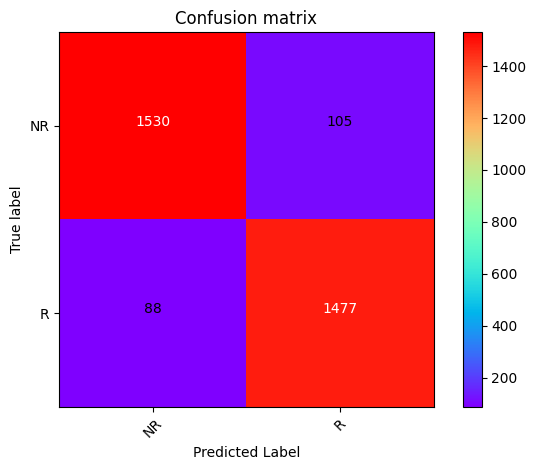

In [40]:
class_names=["NR","R"]
print(__doc__)

def plot_confusion_matrix(cm,classes,normalize=False,title='Confusion matrix',cmap=plt.cm.rainbow):
    """This function prints and plots the confusion matrix.
       Normalization can be applied by setting 'normalize = True'"""
    if normalize:
        cm=cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    print(cm)
    
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,format(cm[i,j],fmt),horizontalalignment="center",color="white" if cm[i,j]>thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    
# Compute confusion matrix
cnf_matrix=confusion_matrix(y_test_le,preds)
np.set_printoptions(precision=2)

#Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix,classes=class_names,title='Confusion matrix')

#Plot normalized confusion matrix
#plt.figure()
#plot_confusion_matrix(cnf_matrix,classes=class_names,normalize=True, title='Normalized Confusion matrix')
plt.show()

In [41]:
from sklearn.metrics import accuracy_score
accuracy_score((y_test_le),preds)

0.9396875

In [42]:
from sklearn.metrics import recall_score
recall_score((y_test_le),preds)

0.9437699680511182

In [43]:
from sklearn.metrics import precision_score
precision_score((y_test_le),preds)

0.9336283185840708

In [44]:
from sklearn.metrics import f1_score
f1_score((y_test_le),preds)

0.9386717508738481

<b>Evaluation Metrics</b>

In [45]:
from sklearn.metrics import classification_report
lst=(classification_report((y_test_le),preds, target_names=class_names))
print(lst)

              precision    recall  f1-score   support

          NR       0.95      0.94      0.94      1635
           R       0.93      0.94      0.94      1565

    accuracy                           0.94      3200
   macro avg       0.94      0.94      0.94      3200
weighted avg       0.94      0.94      0.94      3200



<h1>Naive bayes</h1>

In [46]:
from sklearn.naive_bayes import GaussianNB
nav_clf = GaussianNB()
nav_clf.fit(X_train_s, y_train_le)
predict_nav = nav_clf.predict(X_test_s)
#pred1 = (predict_nav >= 0.5).astype("int").ravel()
accuracy_score(y_test_le, predict_nav)

#naive=(classification_report((y_test_le),pred1, target_names=class_names))

0.500625

In [47]:
precision_score((y_test_le),predict_nav)


0.49477351916376305

In [48]:
recall_score((y_test_le),predict_nav)


0.9980830670926517

In [49]:
f1_score((y_test_le),predict_nav)

0.6615840745446844

In [50]:
from sklearn.neighbors import KNeighborsClassifier

KN = KNeighborsClassifier()
KN.fit(X_train_s, y_train_le)
predict_kn = KN.predict(X_test_s)
accuracy_score(y_test_le, predict_kn)
#pred2 = (predict_kn >= 0.5).astype("int").ravel()
#knnn=(classification_report((y_test_le),pred2, target_names=class_names))

0.7678125

In [51]:
precision_score((y_test_le),predict_kn)


0.7461077844311377

In [52]:
recall_score((y_test_le),predict_kn)


0.7961661341853035

In [53]:
f1_score((y_test_le),predict_kn)

0.7703245749613601

In [54]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()
log_reg.fit(X_train_s, y_train_le)
predict_log = log_reg.predict(X_test_s)
accuracy_score(y_test_le, predict_log)
#pred3 = (predict_log >= 0.5).astype("int").ravel()
#logi=(classification_report((y_test_le),pred3, target_names=class_names))


C:\Users\Vriddhi Agarwal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.530625

In [55]:
precision_score((y_test_le),predict_log)

0.5115257958287596

In [56]:
recall_score((y_test_le),predict_log)


0.8932907348242811

In [57]:
f1_score((y_test_le),predict_log)

0.6505351326198232

In [58]:
from sklearn.ensemble import RandomForestClassifier

In [59]:
rand_clf = RandomForestClassifier()
rand_clf.fit(X_train_s, y_train_le)
predict = rand_clf.predict(X_test_s)
accuracy_score(y_test_le, predict)
#pred4 = (predict >= 0.5).astype("int").ravel()
#rf=(classification_report((y_test_le),pred4, target_names=class_names))


0.8990625

In [60]:
precision_score((y_test_le),predict)

0.8687648456057007

In [61]:
recall_score((y_test_le),predict)

0.9348242811501597

In [62]:
f1_score((y_test_le),predict)

0.9005847953216374

In [63]:
from sklearn import tree
dt_clf = tree.DecisionTreeClassifier()
dt_clf.fit(X_train_s, y_train_le)
predict_dt = dt_clf.predict(X_test_s)
accuracy_score(y_test_le, predict_dt)
#pred3 = (predict_log >= 0.5).astype("int").ravel()
print((classification_report((y_test_le),predict_dt, target_names=class_names)))


              precision    recall  f1-score   support

          NR       0.84      0.87      0.86      1635
           R       0.86      0.83      0.84      1565

    accuracy                           0.85      3200
   macro avg       0.85      0.85      0.85      3200
weighted avg       0.85      0.85      0.85      3200



In [64]:

precision_score((y_test_le),predict_dt)

0.8566732412886259

In [65]:
recall_score((y_test_le),predict_dt)

0.8325878594249201

In [66]:
f1_score((y_test_le),predict_dt)

0.8444588464031106

In [67]:

from sklearn.ensemble import GradientBoostingClassifier
grad_clf = GradientBoostingClassifier()
grad_clf.fit(X_train_s, y_train_le)
predict_grad = grad_clf.predict(X_test_s)
accuracy_score(y_test_le, predict_grad)

0.81

In [68]:
precision_score((y_test_le),predict_grad)

0.7806451612903226

In [69]:
recall_score((y_test_le),predict_grad)

0.850479233226837

In [70]:
f1_score((y_test_le),predict_grad)

0.8140672782874618

In [71]:
from sklearn import svm
svm_clf = svm.SVC()
svm_clf.fit(X_train_s, y_train_le)
predict_svm=svm_clf.predict(X_test_s)
accuracy_score(y_test_le, predict_svm)

0.7

In [72]:
precision_score((y_test_le),predict_svm)

0.6797385620915033

In [73]:
recall_score((y_test_le),predict_svm)

0.7309904153354633

In [74]:
f1_score((y_test_le),predict_svm)

0.7044334975369458

In [75]:
sample_text1 = "May ISIS rule the US in future."
sample_text2 = "I had bread in the breakfast"
samples = [sample_text1,sample_text2]
samples_tokens = tk.texts_to_sequences(samples)
samples_paddings=pad_sequences(samples_tokens,maxlen=maxpadlen,padding='post')
samples_rounded_predictions = model.predict(samples_paddings)
#classes_x=np.argmax(samples_rounded_predictions,axis=1)
values = (samples_rounded_predictions >= 0.5).astype("int").ravel()
print(samples_rounded_predictions)
print(values)

1/1 [==============================] - 0s 285ms/step
[[0.33]
 [0.99]]
[0 1]
